# CSI4142 - Group 48 - Assignment 4

---

## Introduction
In this report, we will conduct an empirical study to evaluate a linear regression approach on a regression task. This will be conducted on the Car Details From Dekho daatset. For this study, we will follow the following steps:

#### Group 48 Members
- Ali Bhangu - 300234254
- Justin Wang - 300234186

<br>

---

In [ ]:
!pip3 install Levenshtein


In [88]:
# Importing the required Python libraries
import numpy as npy
import pandas as pd
from fuzzywuzzy import fuzz
import os as os
from scipy.spatial.distance import euclidean
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cityblock
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import Levenshtein
import re
import ast
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN

In [36]:
# Define paths
zip_path = "the-movies-dataset.zip"
target_csv = "movies_metadata.csv"  # The main CSV we want to keep
unwanted_csvs = ["keywords.csv", "credits.csv", "links.csv", "links_small.csv", "ratings.csv", "ratings_small.csv"]  # Unwanted files

# Remove existing files if present
if os.path.exists(target_csv):
    print(f"Existing {target_csv} found. Deleting and re-extracting...")
    os.remove(target_csv)

# Download dataset using curl (Bash command in Jupyter Notebook)
!curl -L -o {zip_path} https://www.kaggle.com/api/v1/datasets/download/rounakbanik/the-movies-dataset

# Extract the ZIP file in the current folder
print("Extracting dataset...")
!unzip -o {zip_path} -d .

# Delete unwanted CSV files
for file in unwanted_csvs:
    if os.path.exists(file):
        os.remove(file)
        print(f"Deleted unwanted file: {file}")

# Verify that the target CSV exists after extraction
if not os.path.exists(target_csv):
    raise FileNotFoundError(f"Dataset not found: {target_csv}. Ensure the ZIP file was correctly extracted.")

Existing movies_metadata.csv found. Deleting and re-extracting...
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  227M  100  227M    0     0  20.5M      0  0:00:11  0:00:11 --:--:-- 22.0M
Extracting dataset...
Archive:  the-movies-dataset.zip
  inflating: ./credits.csv           
  inflating: ./keywords.csv          
  inflating: ./links.csv             
  inflating: ./links_small.csv       
  inflating: ./movies_metadata.csv   
  inflating: ./ratings.csv           
  inflating: ./ratings_small.csv     
Deleted unwanted file: keywords.csv
Deleted unwanted file: credits.csv
Deleted unwanted file: links.csv
Deleted unwanted file: links_small.csv
Deleted unwanted file: ratings.csv
Deleted unwanted file: ratings_small.csv


In [37]:
movieSet = pd.read_csv(target_csv)
print("Dataset loaded successfully.")

movieSet.head()
movieSet.info()

Dataset loaded successfully.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45

/var/folders/8n/7vlzl5wn25x2wt_mzqszvnbm0000gn/T/ipykernel_21009/621069896.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  movieSet = pd.read_csv(target_csv)


## Preparing The Dataset: Cleaning

## 1. Data Cleaning: 

Within this section, we will be running 3 tests to analyze and assess our data. We have chosen to run a presence check, an exact-duplicate check, and a format check. Followed by outlier detection, with a function to replace the outliers with their mean imputated values. 

#### Exact Duplcate Check:

After validating the presence check for the attributes we deemed critical, we replaced the missing values in revenue and runtime with their respective mean values via mean imputation and utilized an Abritrary Value of 2000-01-01 (Janaury 1st, 2000) for the missing release dates. 



Now, we are opting to run an exact duplicate check on our dataset, to remove any discrepancies and accidentally duplicated data within the dataframe. 

In [38]:
# Exact Duplicate Checker: 
movieSet.info()

# Function to check for exact duplicates, dropping the duplicates and keeping the first instance and ensuring the index is reset.
movieSetNew = movieSet.drop_duplicates(keep="first").reset_index(drop=True)
print("Duplicates removed successfully.")

# Checking the new dataset
movieSetNew.head() 
movieSetNew.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

#### Presence Checker:

After running the Exact Duplicate Check, we have opted to run a Presence Check via a modified and enhanced version of our presence checker from Assignment 2 & Assignment 3. We plan to replace missing values in the key attributes with either their mean value, via mean imputation, or via arbitrary values, such as for release date, we will utilize a value of 2000-01-01 (January 1st, 2000) for the missing release dates. 

In [39]:
def presence_checker(df, columns=["genres", "budget", "original_title", "release_date", "revenue", "runtime"]):
    # Filter DataFrame to only check the specified columns
    selected_df = df[columns]
    
    # Count missing values in selected columns
    missing_counts = selected_df.isna().sum()
    
    # Filter to only columns that have missing values
    missing_summary = missing_counts[missing_counts > 0]
    
    if missing_summary.empty:
        print("No missing values found in the specified columns.")
    else:
        print("Missing values detected in the following columns:\n")
        for column, count in missing_summary.items():
            print(f"Column '{column}': {count} missing values")
            print(df[df[column].isna()][[column]].head(min(5, count)))  # Show up to 5 examples
            print("\n" + "-"*50 + "\n")
    
    return missing_summary

presence_checker(movieSet)


Missing values detected in the following columns:

Column 'release_date': 87 missing values
     release_date
711           NaN
734           NaN
3460          NaN
3628          NaN
5879          NaN

--------------------------------------------------

Column 'revenue': 6 missing values
       revenue
19729      NaN
19730      NaN
29502      NaN
29503      NaN
35586      NaN

--------------------------------------------------

Column 'runtime': 263 missing values
     runtime
634      NaN
635      NaN
644      NaN
802      NaN
863      NaN

--------------------------------------------------



release_date     87
revenue           6
runtime         263
dtype: int64

With the missing values we have found after our check, we decided to replace the numerical categories missing values with their mean and for the release-date attribute, we have opted on using Arbitrary Values to input 2000-01-01 for the missing release dates. 

In [40]:
# Mean Imputation 
def fill_na_with_mean(df, target_column):
    mean_value = df[target_column].mean()  # Calculate mean of the column
    df[target_column] = df[target_column].fillna(mean_value)  # Replace NaNs with mean
    return df

fill_na_with_mean(movieSet, "runtime")
presence_checker(movieSet, ["runtime"])

fill_na_with_mean(movieSet, "revenue")
presence_checker(movieSet, ["revenue"])

# Replace NaN values in 'release_date' with "2000-01-01"
movieSet['release_date'] = movieSet['release_date'].fillna("2000-01-01")

# Arbitrary Value Filled: 
missing_release_date = movieSet['release_date'].isna().sum()
print(missing_release_date)

No missing values found in the specified columns.
No missing values found in the specified columns.
0


#### Format Checker
For our last portion of the data cleaning, we have opted to utilize our Format Checker from Assignment 2, we have decided to run it on the release_date column as the format is in the regex pattern of `pattern = r'^\d{4}-\d{2}-\d{2}$'`

In [41]:
# Column we are checking: 
column = 'release_date'
# Please enter the regex pattern you would like to check for
pattern = r'^\d{4}-\d{2}-\d{2}$'

# Format Check Test: 
def format_checker(df, column, pattern):
    # creating the regex pattern
    regex = re.compile(pattern)
    
    # Applying the regex pattern to the column and filters the rows that don't match
    mismatched_rows = df[~df[column].astype(str).apply(lambda x: bool(regex.match(x)))]
    total_mismatched = mismatched_rows.shape[0]
    
    # Printing the results of the format check. 
    print(f"There are {total_mismatched} data points in {column} that do not match the format {pattern}. \nSee below for examples if there are mismatched rows:")
    
    # Outputting the mismatched rows for the user to see
    if total_mismatched > 0:
        print("\nHere are some of the rows of mismatched format:")
        print(mismatched_rows.head(3))  

# Running the function with parameters defined above:
format_checker(movieSet, column, pattern)

There are 3 data points in release_date that do not match the format ^\d{4}-\d{2}-\d{2}$. 
See below for examples if there are mismatched rows:

Here are some of the rows of mismatched format:
                                                   adult  \
19730                                 - Written by Ørnås   
29503   Rune Balot goes to a casino connected to the ...   
35587   Avalanche Sharks tells the story of a bikini ...   

      belongs_to_collection                            budget  \
19730              0.065736  /ff9qCepilowshEtG2GYWwzt2bs4.jpg   
29503              1.931659  /zV8bHuSL6WXoD6FWogP9j4x80bL.jpg   
35587              2.185485  /zaSf5OG7V8X8gqFvly88zDdRm46.jpg   

                                                  genres  \
19730  [{'name': 'Carousel Productions', 'id': 11176}...   
29503  [{'name': 'Aniplex', 'id': 2883}, {'name': 'Go...   
35587  [{'name': 'Odyssey Media', 'id': 17161}, {'nam...   

                                                homepage        

#### Formatting Genres

We have opted to format genres in an acceptable way instead of as they are currently outputted. We are using Python's built-in Abstract Syntax Tree list into our program to utilize. This way we have our genres formatted in a manner that we can utilize in our studies. 

In [42]:
def clean_genres(df, column):
    df[column] = df[column].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])
    df[column] = df[column].apply(lambda x: [genre['name'] for genre in x] if isinstance(x, list) else [])
    return df

clean_genres(movieSet, "genres")
movieSet.head()


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,[Comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


---
## 2. EDA 

Within this section, we are using Seaborn and MatplotLib to conduct exploratory data analysis to explore if there is any correlation between attributes within our data set. 

This scatter plot visualizes the relationship between a movie's production budget and its revenue. Since both are continuous numerical features included in the dataset, this plot helps us identify the spread and correlation of these two dimensions.  The plot also highlights data skew, potential outliers (e.g., extreme blockbusters), and whether high budgets generally lead to high revenue—insights that can influence our feature selection and scaling strategies later in the assignment.


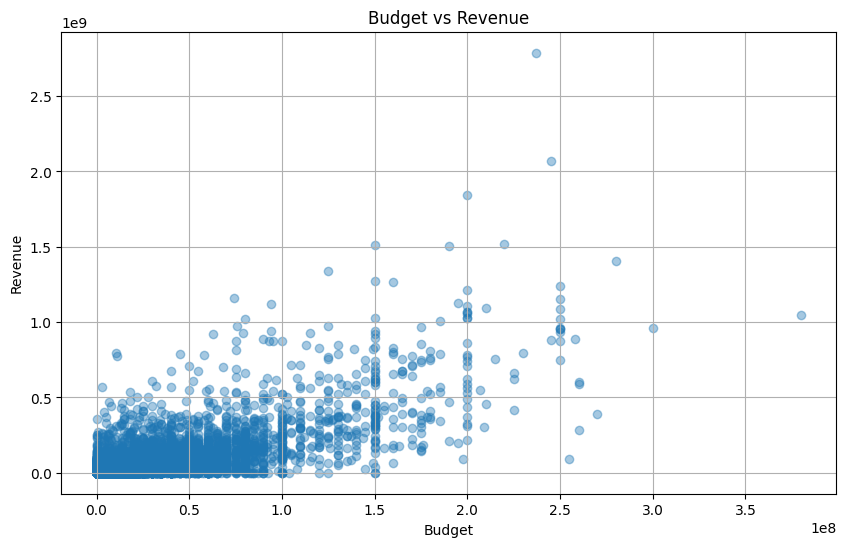

In [82]:
plt.figure(figsize=(10, 6))
plt.scatter(movieSet['budget'], movieSet['revenue'], alpha=0.4)
plt.title("Budget vs Revenue")
plt.xlabel("Budget")
plt.ylabel("Revenue")
plt.grid(True)
plt.show()

We are conducting a top genre count for Jaccard Simularity Measures & Clustering, Study 1 and Study 3 respectively, this will assist us in choosing the most frequent genres to test for similarity. 

In [81]:
# Calculating the Top 10 Genres 
genre_list = [g for genres in movieSet['genres'] for g in genres]
genre_counts = Counter(genre_list)

# Convert the genre counts to a DataFrame for better visualization
genre_df = pd.DataFrame(genre_counts.most_common(10), columns=['Genre', 'Count'])
display(genre_df)


,Genre,Count
0,Drama,20265
1,Comedy,13182
2,Thriller,7624
3,Romance,6735
4,Action,6596
5,Horror,4673
6,Crime,4307
7,Documentary,3932
8,Adventure,3496
9,Science Fiction,3049


---
### Study 1 - Similarity Measures 

Within this section, we are conducting the following: 

1. Picking a subset of 5 attributes (e.g. Genre, Revenue, Runtime, Title, Budget) in your dataset. 
- The subset of attributes should allow you to explore at least 3 different similarity measures (e.g. Jaccard, Hamming, Cosine, Euclidian, Manhattan). You should also explore an additional similarity measure on textual data (which we have not talked about in class). 

2. Simulate 5 requests to show the results of your 5 similarity measures. 

3. For each request, show the Top 10 results (ranked on the criteria that you choose). 
- For example, for the movies, I could decide to rank on popularity.


We have opted to utilize the following 5 attributes:
1. Budget
2. Genre
3. Runtime
4. Title 
5. Revenue

And the following Similarity Measures:
1. Jaccard
2. Euclidean 
3. Cosine 
4. Manhattan 
5. For Textual Data : Levenshtein Distance Operations

In [43]:
# Jaccard Distance Function: 
def jaccard_similarity(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union != 0 else 0

In [44]:
# Euclidean Distance Function: 

# Using the Scipy Library to calculate the distance between two points
def euclidean_distance(val1, val2):
    return euclidean([val1], [val2])

In [45]:
# Cosine Similarity Function:

# Using the SKLearn Library to calculate the cosine similarity between two points
def cosine_sim(val1, val2):
    return cosine_similarity([[val1]], [[val2]])[0][0] if val1 and val2 else 0

In [46]:
# Levenshtein Distance Function:

# Using the Levenshtein Library to calculate the distance between two strings
def edit_distance(title1, title2):
    return Levenshtein.distance(title1.lower(), title2.lower())

In [ ]:
# Manhattan Distance Function: 
# Using the Scipy Library and the City Block function to calculate the distance between two points 
def manhattan_distance(val1, val2):
    return cityblock([val1], [val2])

### Function For Testing:

If higher_is_better = True:

The function sorts the results in descending order (from highest to lowest similarity score).
This is useful when using Jaccard Similarity or Cosine Similarity, where higher scores indicate greater similarity.
Example: Genre Similarity (Jaccard Score: 0.9 is better than 0.5).
If higher_is_better = False:

The function sorts the results in ascending order (from lowest to highest distance).
This is useful for distance-based measures like Euclidean or Manhattan Distance, where lower values indicate closer matches.
Example: Revenue Similarity (a difference of $10M is better than $500M).

In [67]:
def find_top_similar_movies(target_movie, column, similarity_func, higher_is_better=True):
    if target_movie not in movieSet['original_title'].values:
        return f"Movie '{target_movie}' not found in dataset."

    target_value = movieSet[movieSet['original_title'] == target_movie][column].values[0]

    similarities = []
    for _, row in movieSet.iterrows():
        if row['original_title'] != target_movie:
            # Ensure genres are converted to sets for Jaccard Similarity
            if column == "genres":
                similarity = similarity_func(set(target_value), set(row[column]))
            else:
                similarity = similarity_func(target_value, row[column])
            similarities.append((row['original_title'], float(similarity)))

    # Sort results
    sorted_results = sorted(similarities, key=lambda x: x[1], reverse=higher_is_better)

    # Return top 10 similar movies
    return sorted_results[:10]


In [68]:
find_top_similar_movies("Titanic", "revenue", euclidean_distance, higher_is_better=False)

# This works for this, as we validated it! 

[('Star Wars: The Force Awakens', 223189436.0),
 ('The Avengers', 325476278.0),
 ('Jurassic World', 331505378.0),
 ('Furious 7', 338784828.0),
 ('Avengers: Age of Ultron', 439630494.0),
 ('Harry Potter and the Deathly Hallows: Part 2', 503034188.0),
 ('Frozen', 570815179.0),
 ('Beauty and the Beast', 582147851.0),
 ('The Fate of the Furious', 606269423.0),
 ('Iron Man 3', 629594194.0)]

In [69]:
find_top_similar_movies("The Avengers", "genres", jaccard_similarity, higher_is_better=True)

[('The Tie That Binds', 1.0),
 ('Dream Man', 1.0),
 ('O Convento', 1.0),
 ('Baton Rouge', 1.0),
 ('The Innocent Sleep', 1.0),
 ('U Turn', 1.0),
 ('Stag', 1.0),
 ('Stranger in the House', 1.0),
 ('Hard Rain', 1.0),
 ('Wild Things', 1.0)]

In [70]:
# TO DO LOOK AT THIS EVENTUALLY 

# Ensure 'budget' contains only numeric values and replace invalid entries
movieSet['budget'] = pd.to_numeric(movieSet['budget'], errors='coerce')

# Replace NaN values (from bad data) with 0 or median budget
movieSet['budget'] = movieSet['budget'].fillna(movieSet['budget'].median())

# Convert back to integer for consistency
movieSet['budget'] = movieSet['budget'].astype(int)

# Run similarity search
find_top_similar_movies("Interstellar", "budget", cosine_sim, higher_is_better=True)


[('Toy Story', 1.0),
 ('Jumanji', 1.0),
 ('Waiting to Exhale', 1.0),
 ('Heat', 1.0),
 ('Sabrina', 1.0),
 ('Sudden Death', 1.0),
 ('GoldenEye', 1.0),
 ('The American President', 1.0),
 ('Nixon', 1.0),
 ('Cutthroat Island', 1.0)]

In [71]:
find_top_similar_movies("The Dark Knight", "original_title", edit_distance, higher_is_better=False)


[('The Black Knight', 3.0),
 ('One Dark Night', 3.0),
 ('The Dark Angel', 4.0),
 ('The Good Night', 5.0),
 ('The Long Night', 5.0),
 ('The Dark Wind', 5.0),
 ('Shark Night', 5.0),
 ('The Big Night', 5.0),
 ('The Dark Past', 5.0),
 ('The Last Flight', 5.0)]

In [72]:
find_top_similar_movies("Avatar", "revenue", euclidean_distance, higher_is_better=False)

[('Star Wars: The Force Awakens', 719741463.0),
 ('Titanic', 942930899.0),
 ('The Avengers', 1268407177.0),
 ('Jurassic World', 1274436277.0),
 ('Furious 7', 1281715727.0),
 ('Avengers: Age of Ultron', 1382561393.0),
 ('Harry Potter and the Deathly Hallows: Part 2', 1445965087.0),
 ('Frozen', 1513746078.0),
 ('Beauty and the Beast', 1525078750.0),
 ('The Fate of the Furious', 1549200322.0)]

In [73]:
find_top_similar_movies("The Matrix", "runtime", manhattan_distance, higher_is_better=False)

[('Sense and Sensibility', 0.0),
 ('The Rock', 0.0),
 ('North by Northwest', 0.0),
 ('A Clockwork Orange', 0.0),
 ('Shall we ダンス?', 0.0),
 ('Seven Years in Tibet', 0.0),
 ('He Got Game', 0.0),
 ('The Mask of Zorro', 0.0),
 ("Rosemary's Baby", 0.0),
 ('Star Wars: Episode I - The Phantom Menace', 0.0)]

---
Study 2: Clustering Algorithms 

The purpose of this study is to test 2 different clustering algorithms. We saw KMeans and DBSCAN in class. You are required to test those two algorithms.

For each clustering algorithm, try at least a few variations on the parameters. 
- For KMeans, test at least 2 values for k(1), and for DBSCAN, test at least 2 values for eps and min_samples. A clustering is based on a similarity measure. Use at least 2 different combinations of 2 attributes (from Study 1). 

Limiting the clustering to be on 2 attributes will make it easier to do visual inspection on the resulting clusters.
Show your visual inspection results(2) for your combinations of attributes. For example, for the movie dataset, I can cluster and visualize results on (Revenue versus Budget) and (Runtime versus Budget), and that for each of the clustering algorithm.

Discuss which clustering algorithm (KMeans versus DBSCAN) seems more appropriate based on your visual inspection. Beyond visual inspection, you can also explore the cluster metrics we discussed in class (Cluster magnitude and cardinality), but that is optional.

Notes:
1. You can also try to find the best value for K using the method shown during the lecture (trying k from small to large and measuring the cumulated magnitude over all clusters). That is optional.
2. There is a lot of code online to do that, such as shown in the Demo of DBSCAN clustering algorithm (link) in sklearn.


In [90]:
# Select feature pairs
X1 = movieSet[['budget', 'revenue']].copy()
X2 = movieSet[['runtime', 'budget']].copy()

# Standardize both
X1_scaled = StandardScaler().fit_transform(X1)
X2_scaled = StandardScaler().fit_transform(X2)


for k in [3, 5]:
    kmeans1 = KMeans(n_clusters=k, random_state=42, n_init='auto').fit(X1_scaled)
    kmeans2 = KMeans(n_clusters=k, random_state=42, n_init='auto').fit(X2_scaled)

    print(f"KMeans clustering on Budget vs Revenue with k={k}:")
    print(pd.Series(kmeans1.labels_).value_counts(), "\n")

    print(f"KMeans clustering on Runtime vs Budget with k={k}:")
    print(pd.Series(kmeans2.labels_).value_counts(), "\n")


KMeans clustering on Budget vs Revenue with k=3:
0    43517
2     1674
1      275
Name: count, dtype: int64 

KMeans clustering on Runtime vs Budget with k=3:
1    39994
0     4266
2     1206
Name: count, dtype: int64 

KMeans clustering on Budget vs Revenue with k=5:
0    41897
2     2315
1      879
4      281
3       94
Name: count, dtype: int64 

KMeans clustering on Runtime vs Budget with k=5:
1    39037
0     3770
4     2089
2      384
3      186
Name: count, dtype: int64 



In [91]:
for eps, min_samples in [(0.5, 5), (1.0, 10)]:
    db1 = DBSCAN(eps=eps, min_samples=min_samples).fit(X1_scaled)
    db2 = DBSCAN(eps=eps, min_samples=min_samples).fit(X2_scaled)

    print(f"DBSCAN clustering on Budget vs Revenue (eps={eps}, min_samples={min_samples}):")
    print(pd.Series(db1.labels_).value_counts(), "\n")

    print(f"DBSCAN clustering on Runtime vs Budget (eps={eps}, min_samples={min_samples}):")
    print(pd.Series(db2.labels_).value_counts(), "\n")


DBSCAN clustering on Budget vs Revenue (eps=0.5, min_samples=5):
 0     45180
-1       214
 6        11
 8        10
 4         9
 5         7
 9         6
 1         5
 2         5
 3         5
 11        5
 10        5
 7         4
Name: count, dtype: int64 

DBSCAN clustering on Runtime vs Budget (eps=0.5, min_samples=5):
 0    45381
-1       58
 2       16
 1       11
Name: count, dtype: int64 

DBSCAN clustering on Budget vs Revenue (eps=1.0, min_samples=10):
 0    45341
-1      125
Name: count, dtype: int64 

DBSCAN clustering on Runtime vs Budget (eps=1.0, min_samples=10):
 0    45410
-1       26
 2       19
 1       11
Name: count, dtype: int64 

